# Statistical Arbitrage

In this notebook, we will create a pairs trading strategy between two cointegrated instruments(two ETFs EWA and EWC). 

## Pairs Trading strategy 

* Statistical Arbitrage is a group of trading strategies employing large, diverse portfolio that are traded on a very short-term basis.
* An example of a statistical arbitrage is pairs trading strategy.
* Pairs trading is a contrarian strategy designed to harness mean-reverting behavior of cointegrated instruments. This is mainly because cointegrated pairs are assumed to be mean reverting in nature.
* Hence, we need to find two instruments that are cointegrated. The way to find cointegrated instruments is by forming a portfolio such that the portfolio is stationary. If the portfolio is stationary ,then the instruments in the portfolio are said to be cointegrated and suitable for our strategy. 

## Importing libraries
Importing the relevant libraries for coding the pairs trading strategy. The Numpy library will be used to vectorizated computations. Pandas is used for taking advantage of its useful dataframes and matplotlib for plotting the cumulative returns of the strategy. Yfinance will be used for downloading financial data. The OLS library function from the statsmodes.api will be used to do an ordinary least square regression, the adfuller function from the statsmodels.tsa.stattools module to perform an augmented dickey-fuller test and finally, the tabulate library function will be handy when printing the summary of the strategy.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from tabulate import tabulate
from statsmodels.api import OLS
from statsmodels.tsa.stattools import adfuller

## Downloading finncial data from yahoo finance
Download financial data for the two ETS: EWA and EWC for dates from 2010-01-01 to 2020-12-31.  

In [2]:
# download the data
EWA = yf.download( "EWA", start = "2010-01-01", end = "2020-12-31")['Adj Close']
EWC = yf.download( "EWC", start = "2010-01-01", end = "2020-12-31")['Adj Close']

# Place both data on a single dataframe with their respected labels
df = pd.concat( [EWA, EWC], axis  = 1 )
df.columns = ['EWA', 'EWC']
df.index = pd.to_datetime( df.index)
# let's look at the dataframe
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,EWA,EWC
Date,,
2010-01-04,14.475681,21.276281
2010-01-05,14.518399,21.394831
2010-01-06,14.573325,21.560804
2010-01-07,14.506198,21.489674
2010-01-08,14.677072,21.600327


## Plotting the price changes of the two ETFs 

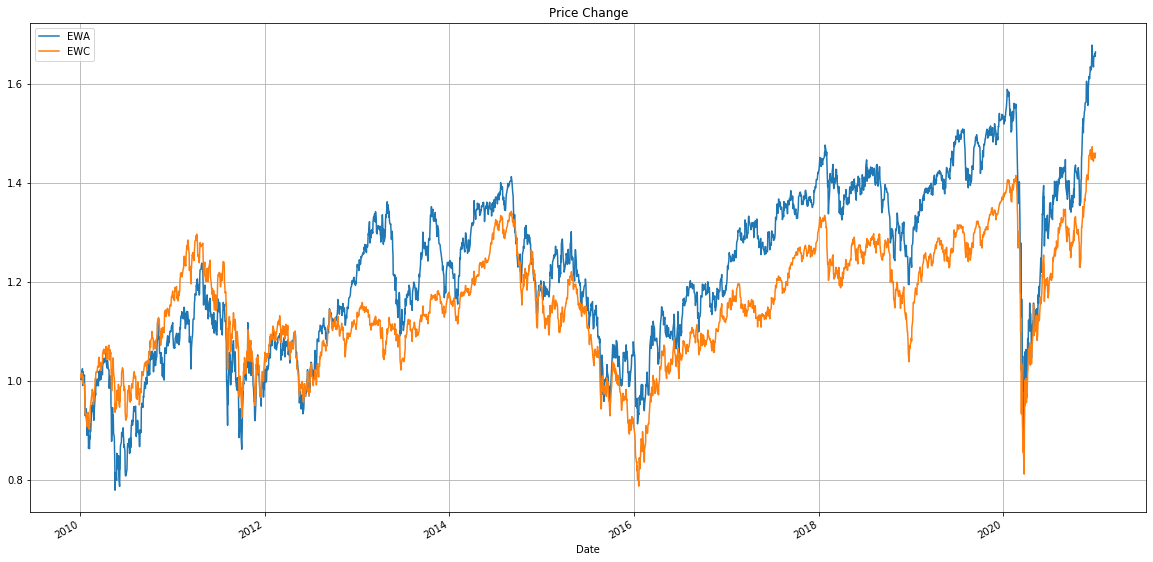

In [3]:
(df.pct_change() + 1).cumprod().plot( figsize = (20,10),grid = True)
plt.title( "Price Change")
plt.show()

## Finding the hedge ratio
* Not any arbitrary combination of the instruments will result on cointegrated pairs.
* Only some combinations of the instruments are cointegrated (meaning the portfolio is stationary).
* We will be do a linear regression to find the hedge ratio 

In [4]:
# use the function OLS to do an ordinary least squares regression
model = OLS( df['EWC'].iloc[:90], df['EWA'].iloc[:90] ) 
model = model.fit() 
model.params

EWA    1.509483
dtype: float64

## Create the spread

Consider the two ETFs as X(EWA) and Y(EWC)

We found the hedge ratio which was a linear regression between X and Y. 

Spread = Y- hedge_ratio*X


The Spread is: EWC -1.509483 *EWA


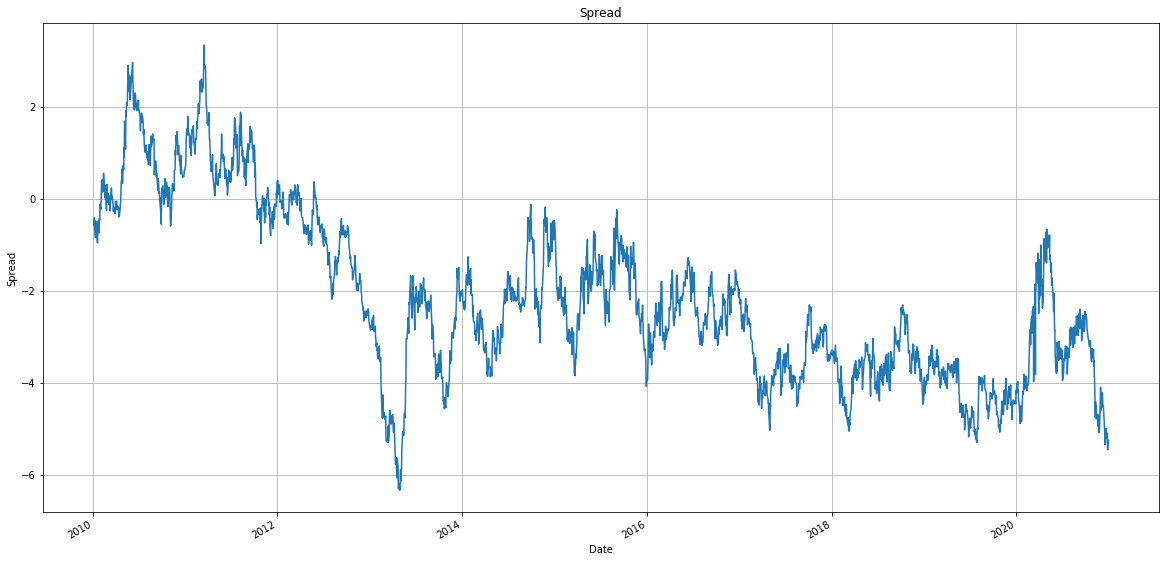

In [5]:
# Use the formula to calculate the Spread of the portfolio
df['Spread'] = df['EWC'] - model.params[0]*df['EWA']

print( f"The Spread is: EWC -%f *EWA"%(model.params[0]) )

# Plot the Spread 
df['Spread'].plot( figsize = (20,10), grid = True )
plt.title("Spread")
plt.ylabel("Spread")
plt.show()

## ADF test(test for checking the stationarity of the Spread)

In [6]:
# apply the adf test to the Spread
adf = adfuller(df['Spread'], maxlag = 1)

# show the t-stat value 
adf[0]

-2.550064300042554

In [7]:
adf[4] # show the critical values

{'1%': -3.432716369874773,
 '5%': -2.8625854938408413,
 '10%': -2.5673265493658404}

We can't conclude with 90% certainty that the spread is stationary. But -2.55 is really close to -2.56 which it could seems as acceptable to perform the mean reversion strategy. 

# Mean Reversion Strategy 

Function which implements a mean reversion strategy

In [8]:
def mean_reversion_strategy( df, look_back_window, std_dev):
    '''
    Takes as input a dataframe df, 
                 an integer look_back_window which represents the lookback period
                 an integer std_dev which represents the bollinger bands
               it returns an updated version of the dataframe with the trading positions
    '''
    
    # Calculate the moving average and moving standard deviation
    df['Moving Average'] = df['Spread'].rolling(window = look_back_window).mean()
    df['Moving_std'] = df['Spread'].rolling(window = look_back_window).std()
    
    # Calculate the Lower and Upper band 
    df['Upper_band'] = df['Moving Average'] + df['Moving_std']*std_dev
    df['Lower_band'] = df['Moving Average'] - df['Moving_std']*std_dev
    
    
    # Long Positions (Buy when is low and closed position once the spread goes back to the mean)
    df['long_entry'] = df['Spread'] < df['Lower_band'] 
    df['long_exit'] = df['Spread'] >= df['Moving Average']
    df['Positions_long'] = np.nan
    df.loc[ df.long_entry, 'Positions_long'] = 1 
    df.loc[ df.long_exit, 'Positions_long'] = 0 
    
    df['Positions_long'] = df['Positions_long'].fillna(method = "ffill")
    
    # Short Positions (Sell when is high and closed position once the spread goes back to the mean)
    df['short_entry'] = df['Spread'] > df['Upper_band'] 
    df['short_exit'] = df['Spread'] <= df['Moving Average'] 
    
    df['Positions_short'] = np.nan 
    
    df.loc[df.short_entry, 'Positions_short'] = -1 
    df.loc[ df.short_exit, 'Positions_short'] = 0 
    
    df['Positions_short'] = df['Positions_short'].fillna(method = "ffill")
    
    
    # Positions (Combine both long and short positions)
    df['Positions'] = df['Positions_long'] + df['Positions_short']
    
    return df
    

In [9]:
df = mean_reversion_strategy(df, 30, 2)

## Analysing Model output

#### Calculate cumulative returns
Calculate and plot the cumulative returns

***Note: The returns were calculated without taking in consideration the transaction costs***

In [29]:
df['Percentage_change'] = (df['Spread'] -df['Spread'].shift(1) )/(df['EWA'] + df['EWC'] ) 
df['Strategy_Return'] = df['Positions'].shift(1)*df['Percentage_change']
df['Cumulative_return'] = (df['Strategy_Return'] + 1).cumprod()

"The Strategy Returns are %.2f"%( (df['Cumulative_return'].iloc[-1] -1 )*100  )

'The Strategy Returns are 36.68'

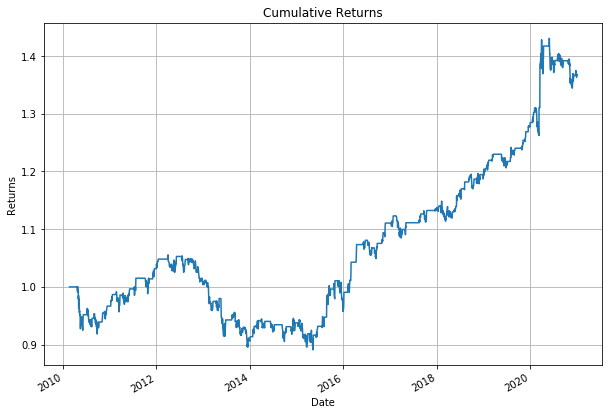

In [11]:
df.Cumulative_return.plot(label='Returns', figsize=(10,7))  
plt.xlabel('Date')  
plt.grid(True)
plt.title("Cumulative Returns")
plt.ylabel('Returns')  
plt.show()

#### Calculate drawdowns
Calculate the drawdowns and plot the dradowns of the strategy

In [12]:
def cal_drawdown(cum_returns):
    '''
    Function that calculates the drawdowns of the strategy
    Takes as input series cum_returns 
    and it returns a series drawdown.   
    '''
    running_max = np.maximum.accumulate(cum_returns.dropna() )
    running_max[running_max < 1 ] = 1
    drawdown = (cum_returns)/running_max -1
    return drawdown 

In [13]:
drawdown = cal_drawdown(df.Cumulative_return)

print( f"Maximum Drawdown is {drawdown.min()*100} %" )

Maximum Drawdown is -15.59948912171042 %


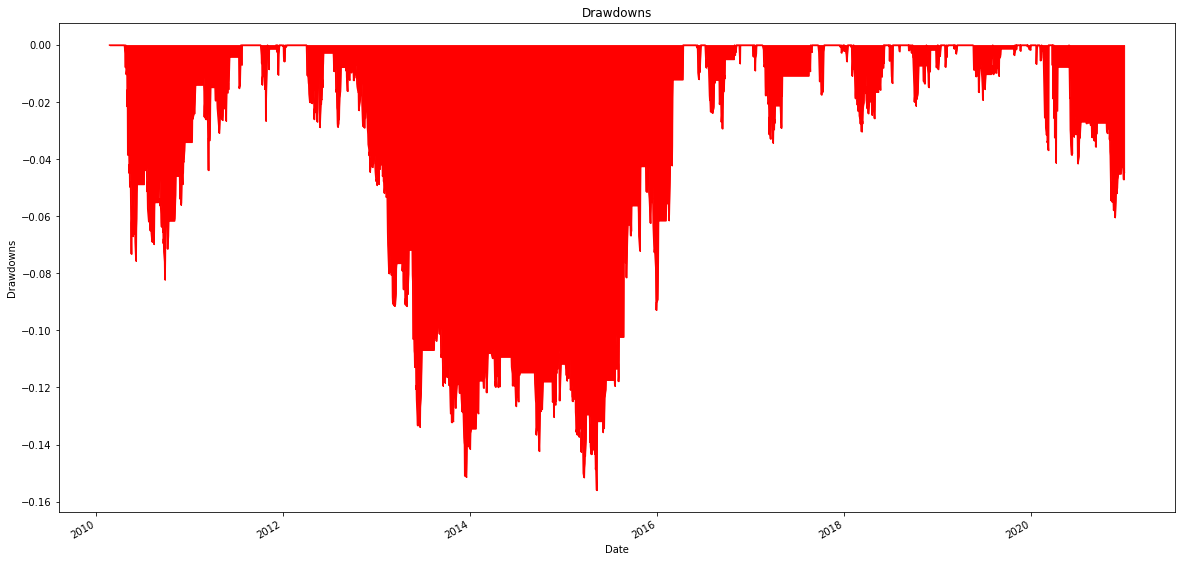

In [23]:
drawdown.plot( figsize = (20,10), color = 'r')
plt.ylabel("Drawdowns")
plt.title( "Drawdowns" )
plt.fill_between(drawdown.index, drawdown, color = 'red')
plt.show()

#### Calculate the number of trades, positive trades, negative trades, Hit Ratio, Sharpe Ratio of the strategy, the standard deviation of returns, average profit to average loss

In [24]:
# Calculate the number of positive trades
df['Positive Trades'] = np.where( df['Strategy_Return'] > 0 , 1, 0 )

# Calculate the number of negative trades
df['Negative Trades'] = np.where( df['Strategy_Return'] < 0 , 1, 0 )

# Calculate the number of trades executed during the strategy
total_trades = df['Positive Trades'].sum() + df['Negative Trades'].sum()

# Calculate the Hit Ratio (Success Ratio of Trades)
df['Hit Ratio'] = df['Positive Trades'].sum()/total_trades 

# Calculate the Sharpe Ratio
df['Sharpe_Ratio'] = df['Strategy_Return'].mean()/df['Strategy_Return'].std()

# Calculate Standard Deviation of Returns
df['Std_dv_Returns'] = df['Strategy_Return'].std()

# Calculate the Average Profit to Average Loss
Average_Profit = np.where(df['Strategy_Return'] > 0, df['Strategy_Return'] , 0 ).sum()/total_trades
Average_Loss = np.where( df['Strategy_Return'] < 0, df['Strategy_Return'], 0).sum()/total_trades
df['Average Profit to Average Loss'] = abs( Average_Profit/Average_Loss )


In [25]:
df.tail(3) # checking the updated dataframe 

,EWA,EWC,Spread,Moving Average,Moving_std,Upper_band,Lower_band,long_entry,long_exit,Positions_long,...,Positions,Percentage_change,Strategy_Return,Cumulative_return,Positive Trades,Negative Trades,Hit Ratio,Sharpe_Ratio,Std_dv_Returns,Average Profit to Average Loss
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-28,24.049999,30.850000,-5.453057,-4.796283,0.337096,-4.122092,-5.470475,False,False,1.0,...,1.0,-0.006850,-0.006850,1.363380,0,1,0.514467,0.029513,0.004168,1.122266
2020-12-29,23.959999,30.930000,-5.237204,-4.811656,0.346524,-4.118609,-5.504703,False,False,1.0,...,1.0,0.003932,0.003932,1.368741,1,0,0.514467,0.029513,0.004168,1.122266
2020-12-30,24.090000,31.049999,-5.313439,-4.830227,0.358188,-4.113851,-5.546603,False,False,1.0,...,1.0,-0.001383,-0.001383,1.366849,0,1,0.514467,0.029513,0.004168,1.122266


#### Printing the summary results of the pairs trading strategy

In [26]:
# Store the Summary result in a nested list
Summary = [ ["Number of Trades", total_trades ], 
            ["Number of Positive Trades", df['Positive Trades'].sum() ], 
            ["Number of Negative Trades", df['Negative Trades'].sum() ], 
            ["Hit Ratio", round( df['Hit Ratio'].iloc[-1], 5) ] , 
            ["Sharpe Ratio", round( df['Sharpe_Ratio'].iloc[-1], 5) ], 
            ["Max Drawdown", str( drawdown.min()*100) + " %"  ]
          ]

# Print the results in a nice table
print("\t\t    Summary")
print("_____________________________________________")
print(tabulate(Summary ,
        headers=['Trading Parameters','Value'],tablefmt='orgtbl'))

		    Summary
_____________________________________________
| Trading Parameters        | Value                |
|---------------------------+----------------------|
| Number of Trades          | 1417                 |
| Number of Positive Trades | 729                  |
| Number of Negative Trades | 688                  |
| Hit Ratio                 | 0.51447              |
| Sharpe Ratio              | 0.02951              |
| Max Drawdown              | -15.59948912171042 % |


## Conclusions

* The performance for this strategy was fairly poor.
* The cummulative returns was 36.68% without taking into account transaction costs. 
* We did 1417 trades during the execution of the pairs strategy where 729 were positives and 688 were negatives. 
* The Hit Ratio(success ratio of trades) was 0.51447 which is not great but it is somewhat acceptable.
* The Sharpe Ratio was 0.02951 which is pretty low, but we need to keep in mind the limitations of the sharpe ratio. 
* The Maximum drawdown was -15.59 % which is a good number. 